In [4]:
import sys
sys.path.insert(1, 'grex2')
import pyximport
pyximport.install()
import yaml
import numpy as np
import grex
from grex.data import extract_data
import grex.utils
import grex.features
from grex.utils import FeaturePredicate

## Profile of object order

In [5]:
patterns = "patterns/patterns_xy_obj_verb_order.yml"
data = "data/x_obj_y_xverb_7255_nomisc.conllu"

with open(patterns) as instream:
    config = yaml.load(instream, Loader=yaml.Loader)

scope = config["scope"]
conclusion = config.get("conclusion", None)
conclusion_meta = config.get("conclusion_meta", None)

templates = FeaturePredicate.from_config(config["templates"])
feature_predicate = FeaturePredicate.from_config(config["features"], templates=templates)

include_metadata = any('meta' in k for k in config.get('features', {}).get('sentence', {}))

data, languages = extract_data(data, scope, conclusion, conclusion_meta, feature_predicate, include_metadata)

# quick checks
if len(data) == 0:
    raise RuntimeError("Patterns resulted in empty dataset")
num_positive = sum(sentence["output"] for sentence in data)
if num_positive == 0:
    raise RuntimeError("The conclusion does not appear in the dataset")
if num_positive == len(data):
    raise RuntimeError("The conclusion always appears in the dataset")

data_inputs = list()
data_outputs = list()
for sentence in data:
    data_inputs.append(sentence["input"])
    data_outputs.append(sentence["output"])

print("Number of occurences of the conclusion: %i / %i" % (num_positive, len(data)))

print("Extracting features", flush=True)
feature_set = grex.features.FeatureSet()

feature_set.add_feature(grex.features.AllSingletonFeatures())
for degree in range(2, 2 + 1):
    feature_set.add_feature(grex.features.AllProductFeatures(
        degree=degree,
        min_occurences=5
    ))

try:
    feature_set.init_from_data(data_inputs)
    X = feature_set.build_features(data_inputs, sparse=True)
    if X.shape[1] == 0:
        raise RuntimeError("Empty feature list!")
except RuntimeError:
    RuntimeError("There was an error during` feature extraction")

# build targets
y = np.empty((len(data),), dtype=np.int_)
for i, v in enumerate(data_outputs):
    assert v in [0, 1]
    y[i] = v

Number of occurences of the conclusion: 34595 / 41007
Extracting features


In [6]:
lang2idx = {lang: i for i, lang in enumerate(set(languages))}
y_lang = [lang2idx[lang] for lang in languages]

## Proportion vectors

In [7]:
n_langs = max(y_lang) + 1
n_features = X.shape[1]
proportions = np.zeros((n_langs, n_features))

for lang_idx in range(n_langs):
    mask = np.array(y_lang) == lang_idx
    if np.sum(mask) == 0:
        continue
    X_lang = X[mask]
    y_lang_masked = y[mask]
    if np.sum(y_lang_masked) == 0:
        continue
    X_pos = X_lang[y_lang_masked == 1]
    proportions[lang_idx] = X_pos.sum(axis=0) / X_pos.shape[0]

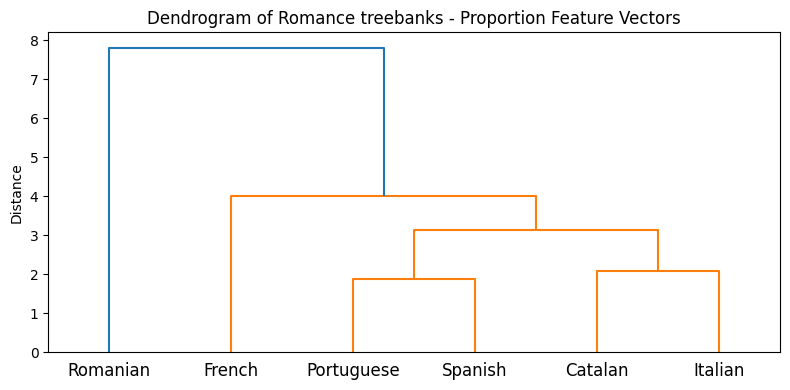

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Z = linkage(proportions, method='ward')

labels = [lang for lang in lang2idx]

plt.figure(figsize=(8, 4))
dendrogram(Z, labels=labels)
plt.title("Dendrogram of Romance treebanks - Proportion Feature Vectors")
plt.ylabel("Distance")
plt.tight_layout()
plt.savefig("dendrogram_prportions.pdf")
plt.show()  

## Entropy vectors

In [10]:
entropy_vectors = np.zeros((n_langs, n_features))

for lang_idx in range(n_langs):
    mask = np.array(y_lang) == lang_idx
    if np.sum(mask) == 0:
        continue
    X_lang = X[mask]
    y_lang_masked = y[mask]
    if np.sum(y_lang_masked) == 0:
        continue
    X_pos = X_lang[y_lang_masked == 1]
    p = X_pos.sum(axis=0).A1 / X_pos.shape[0] # A1 = p = X_pos.sum(axis=0).toarray().flatten()
    p_clip = np.clip(p, 1e-12, 1 - 1e-12)
    entropy = -p_clip * np.log2(p_clip) - (1 - p_clip) * np.log2(1 - p_clip)
    entropy_vectors[lang_idx] = entropy

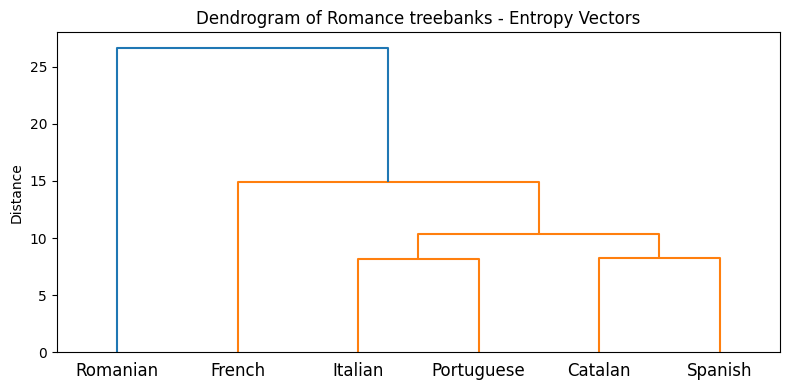

In [12]:
Z = linkage(entropy_vectors, method='ward')

labels = [lang for lang in lang2idx]

plt.figure(figsize=(8, 4))
dendrogram(Z, labels=labels)
plt.title("Dendrogram of Romance treebanks - Entropy Vectors")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()